In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [ ]:
# 파생 변수 생성: "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [ ]:
# 3. 범주형 데이터에 따른 부채확률 따로 구해 참고후 가중치 부여.
loan_period_map = {"단기 상환": 0, "장기 상환": 1}
loan_purpose_map = {
    "교통비": 0, "여행 자금": 1, "교육비": 2, "이사 비용": 3,
    "결혼 자금": 4, "사업 대출": 5, "투자금": 6, "자동차 구매": 7,
    "기타": 8, "부채 통합": 9, "휴가 비용": 10, "주택 개보수": 11
}
job_tenure_map = {
    "5년": 0, "4년": 1, "2년": 2, "6년": 3, "9년": 4,
    "3년": 5, "8년": 6, "10년 이상": 7, "7년": 8, "1년 미만": 9
}
housing_type_map = {"주택임대(월세 포함)": 0, "자가": 1, "주택담보대출(가구 중)": 2, "월세": 3}

col_loan_period = "대출 상환 기간"
col_loan_purpose = "대출 목적"
col_job_tenure = "현재 직장 근속 연수"
col_housing_type = "주거 형태"

for df in [X, test_df]:
    df[col_loan_period] = df[col_loan_period].map(loan_period_map)
    df[col_loan_purpose] = df[col_loan_purpose].map(loan_purpose_map)
    df[col_job_tenure] = df[col_job_tenure].map(job_tenure_map)
    df[col_housing_type] = df[col_housing_type].map(housing_type_map)


In [ ]:
# 함수 정의: Winsorizing & IQR capping
# 원저화: 극한값의 영향을 줄여줌.
# 이 코드에선 상위,하위 1%를 임계값으로 설정.
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower_val = s.quantile(lower_quantile)
    upper_val = s.quantile(upper_quantile)
    return s.clip(lower_val, upper_val)

# 1사분위수와 3사분위수 사이에서 1.5배를 넘는 값 잘라냄.
def iqr_capping(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [ ]:
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for df in [X, test_df]:
    # Winsorizing & 로그 변환
    for col in log_columns:
        df[col] = winsorize_series(df[col], 0.01, 0.99)
        df[col] = np.log1p(df[col])

In [ ]:
for df in [X, test_df]:
    iqr_capping(df, "연간 소득", factor=1.5)

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


k_list = [5, 10, 15, 20, 25, 30]
k_auc_scores = {}

for k in k_list:
    imputer = KNNImputer(n_neighbors=k)
    X_imputed = imputer.fit_transform(X)
    model = LogisticRegression(max_iter=1000)
    scores = cross_val_score(model, X_imputed, y, cv=5, scoring='roc_auc')
    mean_auc = scores.mean()
    k_auc_scores[k] = mean_auc
    print(f"[K={k}] AUC : {mean_auc:.4f}")

[K=5] AUC : 0.6878
[K=10] AUC : 0.6887
[K=15] AUC : 0.6876
[K=20] AUC : 0.6879
[K=25] AUC : 0.6897
[K=30] AUC : 0.6875


In [ ]:
knn_imputer = KNNImputer(n_neighbors=25)
X_imputed = knn_imputer.fit_transform(X)
test_imputed = knn_imputer.transform(test_df)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_tr, y_tr)
val_probs = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"✅ ROC-AUC (Validation Set): {val_auc:.4f}")

✅ ROC-AUC (Validation Set): 0.6915


In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# X_encoded, y 는 미리 전처리된 데이터라고 가정
# 필요 시 imputer + label encoding 진행 후 사용

def objective(trial):
    # 하이퍼파라미터 탐색 범위 정의
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # 스케일링 포함 파이프라인 구성
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            C=C,
            solver=solver,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42
        )
    )

    # 5-Fold Cross Validation 기반 AUC 점수
    score = cross_val_score(model, X_tr, y_tr, cv=5, scoring='roc_auc').mean()
    return score

# 스터디 시작
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 결과 출력
print("✅ 최적 파라미터:", study.best_params)
print("🎯 최고 AUC:", study.best_value)

[I 2025-03-29 05:10:42,656] A new study created in memory with name: no-name-e7b4e8de-7070-4caa-be1f-582e1516dd26
[I 2025-03-29 05:10:42,780] Trial 0 finished with value: 0.6990620445719122 and parameters: {'C': 2.453030525889055e-08, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 0 with value: 0.6990620445719122.
[I 2025-03-29 05:10:42,933] Trial 1 finished with value: 0.7033604616749343 and parameters: {'C': 5077808.811065239, 'solver': 'liblinear', 'class_weight': None}. Best is trial 1 with value: 0.7033604616749343.
[I 2025-03-29 05:10:43,061] Trial 2 finished with value: 0.7031325548374557 and parameters: {'C': 707360259.42629, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7033604616749343.
[I 2025-03-29 05:10:43,248] Trial 3 finished with value: 0.7033734349444506 and parameters: {'C': 39478.63328914994, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 3 with value: 0.7033734349444506.
[I 2025-03-29 05:10:43,470] Trial 4 finished w

✅ 최적 파라미터: {'C': 0.007938803692306557, 'solver': 'liblinear', 'class_weight': None}
🎯 최고 AUC: 0.7034480908303072


In [ ]:
from sklearn.linear_model import LogisticRegression

best_model = LogisticRegression(
    random_state=42,
    C=0.007938803692306557,
    solver='liblinear'
)

best_model.fit(X_tr, y_tr)

LogisticRegression(C=0.007938803692306557, random_state=42, solver='liblinear')

In [ ]:
# 테스트 데이터 예측 & 저장
test_preds = best_model.predict_proba(test_scaled)[:, 1]
submission = pd.DataFrame({"UID": test_uid["UID"], "채무 불이행 확률": test_preds})
submission.to_csv("submission.csv", index=False)
print("✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.")

✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.


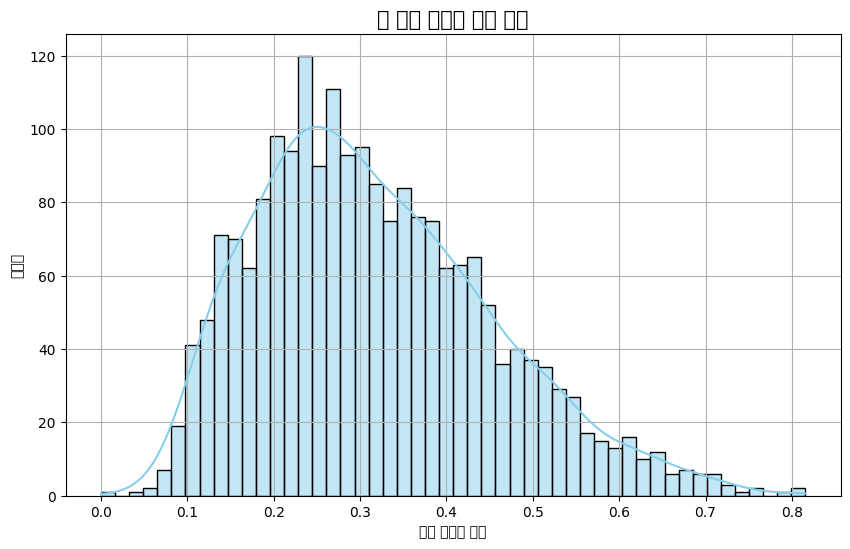

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 불러오기
df = pd.read_csv("submission.csv")

# 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df["채무 불이행 확률"], bins=50, kde=True, color="skyblue")
plt.title("🔍 채무 불이행 확률 분포", fontsize=15)
plt.xlabel("채무 불이행 확률")
plt.ylabel("빈도수")
plt.grid(True)
plt.show()